# 1. Load Dataset and Quick Overview

In [3]:
# import libraries
import pandas as pd
import numpy as np

# load dataset
df = pd.read_csv('../data/ab_data.csv')

# Quick structure check
df.info()

# Display first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Basic sanity check
print("Number of rows:", len(df))
print("Unique users:", df['user_id'].nunique())
print("Duplicated users:", df['user_id'].duplicated().sum())

# Basic group and conversion counts
print(df['group'].value_counts())
print(df['converted'].value_counts())

Number of rows: 294478
Unique users: 290584
Duplicated users: 3894
group
treatment    147276
control      147202
Name: count, dtype: int64
converted
0    259241
1     35237
Name: count, dtype: int64


Groups assignment is **balanced** (`treatment` = 147276, `control` = 147202).

We have **3894** duplicated users, they should be deleted.

# 2. Initial cleaning

- removing duplicate `user_id`s
- dropping rows with mismatching `group`/`landing_page` pairs ('control' = 'old_page', 'treatment' = 'new_page')

In [ ]:
# removing duplicated
# sorting by timestamp to leave only first occurrences
df = df.sort_values(by='timestamp')

# dropping duplicates
df = df.drop_duplicates(subset=['user_id'], keep='first')

df = df.sort_values(by='timestamp', ascending=False)

# dropping rows with mismatching group/landing_page pairs
# check mismatched combinations
mismatched = df.query(
    "(group == 'treatment' and landing_page != 'new_page') "
    "or (group == 'control' and landing_page != 'old_page')"
)

print("Number of mismatched rows:", len(mismatched))

# dropping mismatches
df = df.drop(mismatched.index)

# double-check that all combinations are now valid
df.groupby('group')['landing_page'].value_counts()

Number of mismatched rows: 1949


group      landing_page
control    old_page        144319
treatment  new_page        144316
Name: count, dtype: int64

# 3. Exploratory Data Analysis

- Group & Conversion Overview
- Quick Visualization
- Check Random Assignment Balance
- Optional Extra Peek

In [17]:
# group sizes
group_counts = df['group'].value_counts()
print("Group sizes:\n", group_counts, "\n")

# conversion rate by group
conversion_rates = df.groupby('group')['converted'].mean() * 100
print("Conversion rates (%):\n", conversion_rates, "\n")

# Summary DataFrame
summary = pd.DataFrame({
    'Users': df['group'].value_counts(),
    'Converted (%)': df.groupby('group')['converted'].mean() * 100
})
summary['Converted (%)'] = summary['Converted (%)'].round(2)
summary

Group sizes:
 group
control      144319
treatment    144316
Name: count, dtype: int64 

Conversion rates (%):
 group
control      12.039302
treatment    11.869786
Name: converted, dtype: float64 



,Users,Converted (%)
group,,
control,144319,12.04
treatment,144316,11.87


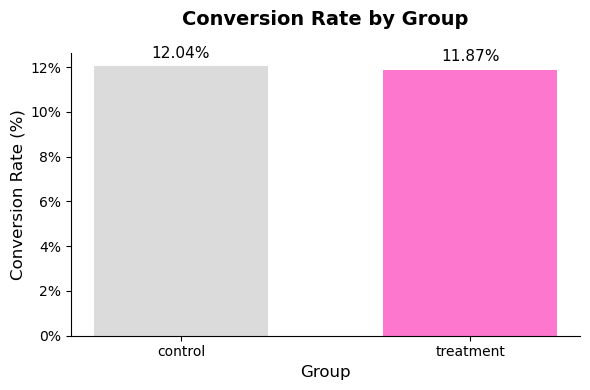

In [40]:
import matplotlib.pyplot as plt

# Values
groups = conversion_rates.index
rates = conversion_rates.values

plt.figure(figsize=(6,4), facecolor='white')

bars = plt.bar(groups, rates, color=["#dbdbdb", "#fe77ce"], width=0.6)

# Title and labels (added more top padding)
plt.title('Conversion Rate by Group', fontsize=14, weight='bold', pad=20)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Group', fontsize=12)

# Keep only left (y-axis) and bottom (x-axis) spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format y-axis with % sign
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Remove grid lines
plt.grid(False)

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.25,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.tight_layout()
plt.show()


In [41]:
# percentage split
split_ratio = group_counts / group_counts.sum() * 100
print("Sample size ratio (%):\n", split_ratio.round(2))

Sample size ratio (%):
 group
control      50.0
treatment    50.0
Name: count, dtype: float64


In [43]:
# optional extra peek
df['converted'].value_counts(normalize=True) * 100
df['converted'].isna().sum()

np.int64(0)